# MONEAT

An implementation of NEAT for multiobjective Reinforcment Learning

## Imports

In [2]:
import mo_gymnasium as gym
from deap import algorithms, tools, base, creator
import neat
from neat.config import ConfigParameter, DefaultClassConfig
import random
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import math

## Implementation

Implement the moneat structure

### NSGA-2 Reproduction

Use the nsga-2 implementation from deap and import it into neat-python

In [3]:
class NSGA2Reproduction:
    """
    Implements the NSGA-2 reproduction to support multi-objective problems using deap
    """

    @classmethod
    def parse_config(cls, param_dict):
        """
        Same as original
        """
        return DefaultClassConfig(param_dict,
                                  [ConfigParameter('elitism', int, 0),
                                   ConfigParameter('survival_threshold', float, 0.2),
                                   ConfigParameter('min_species_size', int, 1)])


    def __init__(self, config, reporters, stagnation) -> None:
        """
        Same as original
        """
        self.reproduction_config = config
        self.reporters = reporters
        self.genome_indexer = count(1)
        self.stagnation = stagnation
        self.ancestors = {}
        


    """
    Create num_genomes new genomes of the given type using the given configuration.
    """
    def create_new(self, genome_type, genome_config, num_genomes):
        """
        Same as original
        """
        new_genomes = {}
        for i in range(num_genomes):
            key = next(self.genome_indexer)
            g = genome_type(key)
            g.configure_new(genome_config)
            new_genomes[key] = g
            self.ancestors[key] = tuple()

        return new_genomes


    """
    Handles creation of genomes, either from scratch or by sexual or
    asexual reproduction from parents.
    """
    def reproduce(self, config, species, pop_size, generation):
        """Select k individuals using NSGA-II and mutate them"""

        new_population = {}

        for sp in species.species.values():
            members = list(sp.members.values())

            repro_cutoff = max(int(math.ceil(self.reproduction_config.survival_threshold * len(members))), 2)

            chosen = tools.selNSGA2(members, repro_cutoff, 'standard')

            spawn = len(sp.members)

            for i in range(spawn):
                # Pick two random parents
                parent_a = random.choice(chosen)
                parent_b = random.choice(chosen)

                gid = next(self.genome_indexer)
                child = config.genome_type(gid)
                child.configure_crossover(parent_a, parent_b, config.genome_config)
                child.mutate(config.genome_config)
                
                new_population[gid] = child
        return new_population
    



class NSGA2Fitness(float):

    def __new__(cls, value, *args, **kwargs):
        return super(NSGA2Fitness, cls).__new__(cls, value)

    def __init__(self, value, fitness) -> None:
        super().__init__()
        # Add fitness from DEAP
        self.fitness = fitness
        self.values = self.fitness.values
        self.wvalues = self.fitness.wvalues

    def __gt__(self, other) -> bool:
        if isinstance(other, NSGA2Fitness):
            return self.fitness > other.fitness
        return self.fitness > other
    
    def __lt__(self, other) -> bool:
        if isinstance(other, NSGA2Fitness):
            return self.fitness < other.fitness
        return self.fitness < other
    
    def __ge__(self, other) -> bool:
        if isinstance(other, NSGA2Fitness):
            return self.fitness >= other.fitness
        return self.fitness >= other
    
    def __le__(self, other) -> bool:
        if isinstance(other, NSGA2Fitness):
            return self.fitness <= other.fitness
        return self.fitness <= other
    
    def __float__(self) -> float:
        return np.mean(self.fitness.values)
    
    def __str__(self) -> str:
        return str(self.fitness)
 


### NEAT Setup

In [17]:
config_path = 'neat.config'
config = neat.Config(neat.DefaultGenome, NSGA2Reproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)

### Problem

In the minecart problem two different types of ores must be collected while minimizing fuel consumption

In [5]:
env = gym.make("resource-gathering-v0")

obs, info = env.reset()

### Evaluation function

In [18]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0,1.0,1.0))

def evaluate_genome(genome, config):
    net = neat.nn.RecurrentNetwork.create(genome, config)

    fitness = np.zeros(3)
    genome.fitness = NSGA2Fitness(0.0, creator.FitnessMulti(fitness))
    # Fitness is a 3D-vector
    for i in range(10):
        next_obs, info = env.reset()
        for t in range(10000):
            output = net.activate(next_obs)
            action = np.argmax(output)
        
            next_obs, vector_reward, terminated, truncated, info = env.step(action)
            fitness = np.add(fitness, vector_reward)

            if terminated or truncated:
                break
    genome.fitness.fitness.values = fitness


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        evaluate_genome(genome, config)

/Users/gerrit/Uni/SoSe 2024/Bachelorarbeit/MONEAT/venv/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### DEAP Toolbox

In [134]:


# Create fitness function based on the three rewards (maximise ores and minimize fuel)
creator.create("FitnessMulti", base.Fitness, weights=(1.0,1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)


def neat_genome_initializer():
    genome = neat.DefaultGenome(0)
    genome.configure_new(config.genome_config)
    return [genome]

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, neat_genome_initializer)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print(toolbox.individual().fitness)

def evaluate(individual):
    fitness_values = evaluate_genome(individual[0], config)
    return fitness_values

toolbox.register("evaluate", evaluate)

def mate(ind1, ind2):
    ind1 = [ind1]
    ind2 = [ind2]
    child1, child2 = neat.DefaultGenome(0), neat.DefaultGenome(0)
    ind1[0].crossover(ind2, child1, config.genome_config)
    ind2[0].crossover(ind1, child2, config.genome_config)

    return [child1], [child2]

def mutate(ind):
    ind[0].mutate(config.genome_config)
    return [ind]

toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
# use NSGA 2 for selection
toolbox.register("select", tools.selNSGA2)

()


/Users/gerrit/Uni/SoSe 2024/Bachelorarbeit/MONEAT/venv/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/gerrit/Uni/SoSe 2024/Bachelorarbeit/MONEAT/venv/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Training

In [19]:
random.seed(42)

p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

# Run for up to 300 generations.
winner = p.run(eval_genomes, 100)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))
    


 ****** Running generation 0 ****** 

Population's average fitness: -0.08000 stdev: 0.08000
Best fitness: 0.00000 - size: (4, 4) - species 1 - id 1
[<neat.genome.DefaultGenome object at 0x10ec83250>, <neat.genome.DefaultGenome object at 0x10db59b40>, <neat.genome.DefaultGenome object at 0x10ec82fe0>, <neat.genome.DefaultGenome object at 0x10ec81690>, <neat.genome.DefaultGenome object at 0x10ec810c0>, <neat.genome.DefaultGenome object at 0x10ec80520>, <neat.genome.DefaultGenome object at 0x10ec81e10>, <neat.genome.DefaultGenome object at 0x10ec816f0>, <neat.genome.DefaultGenome object at 0x10ec82cb0>, <neat.genome.DefaultGenome object at 0x10ec81db0>, <neat.genome.DefaultGenome object at 0x10ec83b80>, <neat.genome.DefaultGenome object at 0x10ec838e0>, <neat.genome.DefaultGenome object at 0x10ec82e00>, <neat.genome.DefaultGenome object at 0x10ec82230>, <neat.genome.DefaultGenome object at 0x10ec80f70>, <neat.genome.DefaultGenome object at 0x10ecc8ee0>, <neat.genome.DefaultGenome object 

### Evaluation

In [20]:

def evaluate_agent(agent, config, num_episodes=100):
    eval_env = gym.make("fishwood-v0")

    print(agent)

    rewards = []

    for episode in range(num_episodes):
        net = neat.nn.RecurrentNetwork.create(agent, config)
        print(net.values)
        next_obs, info = env.reset()
        episode_reward = np.zeros(3)  # Assuming a 2D reward vector

        for t in range(10000):
            output = net.activate(next_obs)
            print(output)
            action = np.argmax(output)
        
            next_obs, vector_reward, terminated, truncated, info = env.step(action)
            episode_reward = np.add(episode_reward, vector_reward)

            if terminated or truncated:
                break

        rewards.append(episode_reward)
    
    return np.array(rewards)

rewards = evaluate_agent(winner, config)

print(rewards)


#rewards1 = evaluate_agent(new_genome, config)

#print(rewards1)


Key: 3631
Fitness: (np.float64(0.0), np.float64(10.0), np.float64(0.0))
Nodes:
	0 DefaultNodeGene(key=0, bias=0.5033556776969258, response=1.0, activation=tanh, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.43928197778271827, response=1.0, activation=tanh, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-2.844383981397744, response=1.0, activation=tanh, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=-1.9032934312984378, response=1.0, activation=tanh, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-4, 0), weight=-0.5173929410965212, enabled=True)
	DefaultConnectionGene(key=(-4, 2), weight=0.8190525034230853, enabled=True)
	DefaultConnectionGene(key=(-4, 3), weight=-1.1034761986677912, enabled=True)
	DefaultConnectionGene(key=(-3, 1), weight=3.0068743057580254, enabled=True)
[{-1: 0.0, -2: 0.0, -3: 0.0, -4: 0.0, 0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}, {-1: 0.0, -2: 0.0, -3: 0.0, -4: 0.0, 0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}]
[0.850619417576599, 0.799853308288825, -0.9999986679259476,

### Display

In [ ]:
print(rewards)

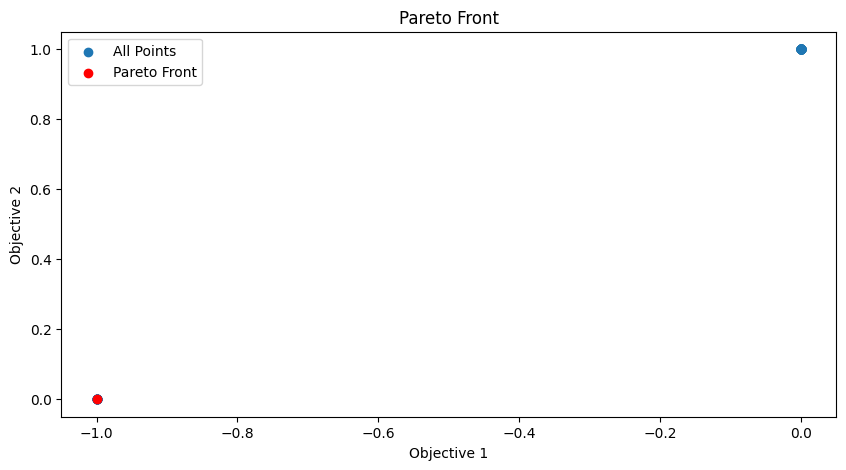

In [9]:
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def plot_pareto_front(rewards):
    pareto_mask = is_pareto_efficient(rewards)
    pareto_front = rewards[pareto_mask]

    plt.figure(figsize=(10, 5))
    plt.scatter(rewards[:, 0], rewards[:, 1], label='All Points')
    plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color='red', label='Pareto Front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title('Pareto Front')
    plt.legend()
    plt.show()

plot_pareto_front(rewards)